CODE BLOCK: 1

<!--
>**This is Bold**
>>*This is Italics*
>>>- Simple statement
>>> - `string`
>>>> - $ mathematical symbols $
>>>> 1. Number 1
>>>> 2. Number 2


&#x25BA;


*** -->

# Session 8 - Assignment
## Basic expectations
- \> = 70% accuracy
- < = 50000
- < = 20 epochs
- C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11 (cN is 1x1 Layer)
- 10 misclassified images display

## Version 2 - Layer Normalization

### Use Layer normalization instead of Batch Normalization

### Results:
- Epochs: 20
- Parameters: 45,960
- Training Batch size: 64
- Testing Batch size: 64
- Training
  - Loss=1.1830
  - Batch_id=781
  - Accuracy=70.50%
- Testing
  - Average loss: 0.8432
  - Accuracy: 7088/10000 (70.88%)

### Analysis:
- Layer Normalization is not giving good results for Images
- Number of parameters also increase due to the size of normalization layer


### [1. Import appropriate modules required in this file](#section-1)
- import model: importing the code written in model.py that is kept in path of current working directory
- import utils: Similarly importing code in utils.py

In [1]:
# !pip install torchsummary

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import utils, model

CODE BLOCK: 2

### [2. Check if GPU (CUDA) or CPU](#section-2)
- Cuda availablbility check to ensure using GPU if available for the network
- Taking the value into device variable if cuda (GPU) or only CPU

In [3]:
SEED = 1

use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if device=="cuda":
    torch.cuda.manual_seed(SEED)

CUDA Available? True


CODE BLOCK: 3

### [3. Data transforms for training and testing](#section-3)
- Transforms specific to the training and testing
- Training to include different transformations for the model to learn
- Testing not to have the same to ensure validation is on normal set

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    # transforms.RandomPerspective(distortion_scale=0.3, interpolation=3, fill=0, p=0.1),
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### [4. Getting the CIFAR10 train and test dataset from torchvision datasets library](#section-4)
- Already separated datasets for train and test
- train with 50000 records and test with *10000* records
- Marking train as True of False decides the train vs test data sets
- The transforms are being loaded from utils file
- transforms being done on train but not on test

In [5]:
train = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

### [5. Data loader setup for Training and Testing](#section-5)
- Batch size definition - Keeping separate for Training and Testing
- Training lower for better training and Testing higher for faster validation
- Data loader definition

In [6]:
batch_size = 64

In [7]:
kwargs = {'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 6

### [6. Data Visualization](#section-6)
- Visualization of data to understand the images and corresponding labels
- Also gives an understanding of the dataloader like Shuffle, etc.

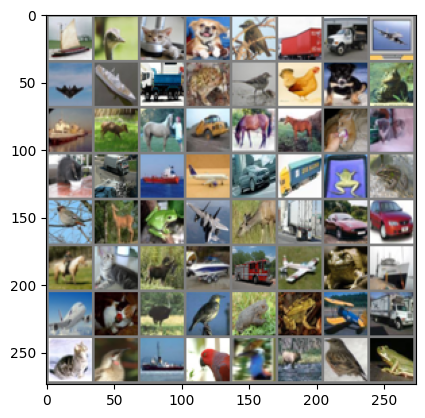

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog 


In [8]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

CODE BLOCK: 10

### [7. Model training](#section-7)
- Loading the model on the right device - CUDA or CPU
- Setting up the right parameters like epochs, optimizer and scheduler for the training
- Running the training and validating the output against Test dataset
- While doing that also storing the loss and accuracy results for each epoch for understanding

In [9]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [10]:
dropout_value = 0.05
mymodel = model.Net8_Layer(dropout_value=dropout_value).to(device)

summary(mymodel, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         LayerNorm-2           [-1, 16, 32, 32]           2,048
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 30, 30]           4,608
         LayerNorm-6           [-1, 32, 30, 30]           1,800
              ReLU-7           [-1, 32, 30, 30]               0
           Dropout-8           [-1, 32, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]             512
           Conv2d-10           [-1, 16, 28, 28]           2,304
        LayerNorm-11           [-1, 16, 28, 28]           1,568
             ReLU-12           [-1, 16, 28, 28]               0
          Dropout-13           [-1, 16, 28, 28]               0
           Conv2d-14           [-1, 32,

In [11]:
debug = False
optimizer = optim.SGD(mymodel.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, threshold_mode='rel', verbose=True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_acc, train_loss = utils.train(mymodel, device, train_loader, optimizer, criterion)
  test_acc, test_loss = utils.test(mymodel, device, test_loader, criterion)
  scheduler.step(test_loss)
  print("LR Rate:", optimizer.param_groups[0]['lr'], "\n")
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  test_accs.append(test_acc)
  test_losses.append(test_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=2.3142 Batch_id=781 Accuracy=9.94: 100%|██████████| 782/782 [00:30<00:00, 25.68it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 2.3047, Accuracy: 4970/50000 (9.94%)


Test set: Average loss: 2.3030, Accuracy: 1053/10000 (10.53%)
LR Rate: 0.01 

Epoch 2


Train: Loss=2.1343 Batch_id=781 Accuracy=14.06: 100%|██████████| 782/782 [00:21<00:00, 36.55it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 2.2760, Accuracy: 7029/50000 (14.06%)


Test set: Average loss: 2.1456, Accuracy: 2257/10000 (22.57%)
LR Rate: 0.01 

Epoch 3


Train: Loss=1.8740 Batch_id=781 Accuracy=31.48: 100%|██████████| 782/782 [00:20<00:00, 38.42it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.9233, Accuracy: 15742/50000 (31.48%)


Test set: Average loss: 1.7238, Accuracy: 3920/10000 (39.20%)
LR Rate: 0.01 

Epoch 4


Train: Loss=1.3406 Batch_id=781 Accuracy=44.09: 100%|██████████| 782/782 [00:20<00:00, 38.53it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.5758, Accuracy: 22047/50000 (44.09%)


Test set: Average loss: 1.4082, Accuracy: 5016/10000 (50.16%)
LR Rate: 0.01 

Epoch 5


Train: Loss=1.3820 Batch_id=781 Accuracy=52.87: 100%|██████████| 782/782 [00:22<00:00, 34.48it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.3405, Accuracy: 26436/50000 (52.87%)


Test set: Average loss: 1.2924, Accuracy: 5511/10000 (55.11%)
LR Rate: 0.01 

Epoch 6


Train: Loss=1.3184 Batch_id=781 Accuracy=58.22: 100%|██████████| 782/782 [00:21<00:00, 36.47it/s]



Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1929, Accuracy: 29111/50000 (58.22%)
Test set: Average loss: 1.1366, Accuracy: 6054/10000 (60.54%)
LR Rate: 0.01 

Epoch 7


Train: Loss=0.7478 Batch_id=781 Accuracy=61.51: 100%|██████████| 782/782 [00:21<00:00, 36.67it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.1038, Accuracy: 30754/50000 (61.51%)


Test set: Average loss: 1.0935, Accuracy: 6229/10000 (62.29%)
LR Rate: 0.01 

Epoch 8


Train: Loss=0.8328 Batch_id=781 Accuracy=63.74: 100%|██████████| 782/782 [00:22<00:00, 34.63it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 1.0372, Accuracy: 31872/50000 (63.74%)


Test set: Average loss: 1.0275, Accuracy: 6421/10000 (64.21%)
LR Rate: 0.01 

Epoch 9


Train: Loss=0.9480 Batch_id=781 Accuracy=65.21: 100%|██████████| 782/782 [00:22<00:00, 34.90it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9943, Accuracy: 32606/50000 (65.21%)


Test set: Average loss: 0.9818, Accuracy: 6621/10000 (66.21%)
LR Rate: 0.01 

Epoch 10


Train: Loss=0.8284 Batch_id=781 Accuracy=66.67: 100%|██████████| 782/782 [00:21<00:00, 36.83it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9525, Accuracy: 33333/50000 (66.67%)


Test set: Average loss: 0.9565, Accuracy: 6708/10000 (67.08%)
LR Rate: 0.01 

Epoch 11


Train: Loss=0.7867 Batch_id=781 Accuracy=68.02: 100%|██████████| 782/782 [00:21<00:00, 36.92it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.9185, Accuracy: 34012/50000 (68.02%)


Test set: Average loss: 0.9217, Accuracy: 6804/10000 (68.04%)
LR Rate: 0.01 

Epoch 12


Train: Loss=1.0512 Batch_id=781 Accuracy=68.86: 100%|██████████| 782/782 [00:21<00:00, 36.60it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8929, Accuracy: 34429/50000 (68.86%)


Test set: Average loss: 0.9307, Accuracy: 6834/10000 (68.34%)
LR Rate: 0.01 

Epoch 13


Train: Loss=0.8080 Batch_id=781 Accuracy=69.77: 100%|██████████| 782/782 [00:21<00:00, 37.03it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8645, Accuracy: 34883/50000 (69.77%)


Test set: Average loss: 0.8819, Accuracy: 6947/10000 (69.47%)
LR Rate: 0.01 

Epoch 14


Train: Loss=0.8393 Batch_id=781 Accuracy=70.41: 100%|██████████| 782/782 [00:21<00:00, 35.83it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8434, Accuracy: 35205/50000 (70.41%)


Test set: Average loss: 0.8834, Accuracy: 6937/10000 (69.37%)
LR Rate: 0.01 

Epoch 15


Train: Loss=0.9353 Batch_id=781 Accuracy=71.17: 100%|██████████| 782/782 [00:22<00:00, 34.04it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8244, Accuracy: 35585/50000 (71.17%)


Test set: Average loss: 0.8699, Accuracy: 7030/10000 (70.30%)
LR Rate: 0.01 

Epoch 16


Train: Loss=0.9829 Batch_id=781 Accuracy=71.87: 100%|██████████| 782/782 [00:22<00:00, 34.08it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.8086, Accuracy: 35935/50000 (71.87%)


Test set: Average loss: 0.8421, Accuracy: 7095/10000 (70.95%)
LR Rate: 0.01 

Epoch 17


Train: Loss=0.6118 Batch_id=781 Accuracy=72.53: 100%|██████████| 782/782 [00:22<00:00, 34.62it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7879, Accuracy: 36267/50000 (72.53%)


Test set: Average loss: 0.8552, Accuracy: 7054/10000 (70.54%)
LR Rate: 0.01 

Epoch 18


Train: Loss=0.8577 Batch_id=781 Accuracy=72.84: 100%|██████████| 782/782 [00:22<00:00, 34.45it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7759, Accuracy: 36421/50000 (72.84%)


Test set: Average loss: 0.8320, Accuracy: 7151/10000 (71.51%)
LR Rate: 0.01 

Epoch 19


Train: Loss=1.1785 Batch_id=781 Accuracy=73.39: 100%|██████████| 782/782 [00:22<00:00, 34.70it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7591, Accuracy: 36697/50000 (73.39%)


Test set: Average loss: 0.8478, Accuracy: 7111/10000 (71.11%)
LR Rate: 0.01 

Epoch 20


Train: Loss=0.7668 Batch_id=781 Accuracy=73.75: 100%|██████████| 782/782 [00:22<00:00, 34.85it/s]


Processed: 50000, Len TrainLoader: 782
Train set: Average loss: 0.7518, Accuracy: 36875/50000 (73.75%)


Test set: Average loss: 0.8367, Accuracy: 7165/10000 (71.65%)
LR Rate: 0.01 



CODE BLOCK: 11

### [8. Model Accuracy and Loss plots visualization](#section-8)
- Part of utils
- Drawing plots of Training and Testing accuracy and loss
- This gives us an understanding of how the accuracy and losses improved over epochs
- Also helps to understand where we should have stopped the training for optimum results

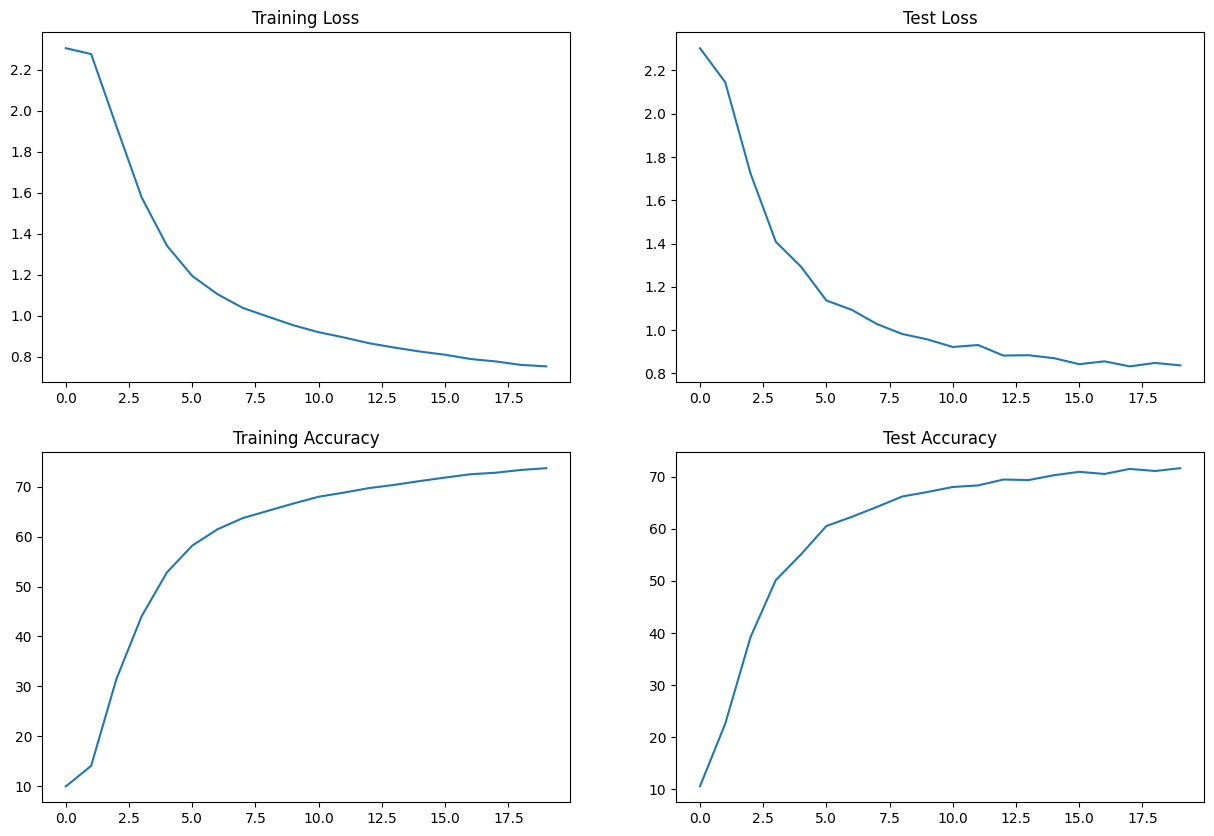

In [12]:
utils.drawLossAccuracyPlots(train_losses, train_accs, test_losses, test_accs)

In [13]:
reqData = 10
images, nonMatchingLabels, incorrectPreds = utils.incorrectOutcomes(mymodel, device, test_loader, reqData)

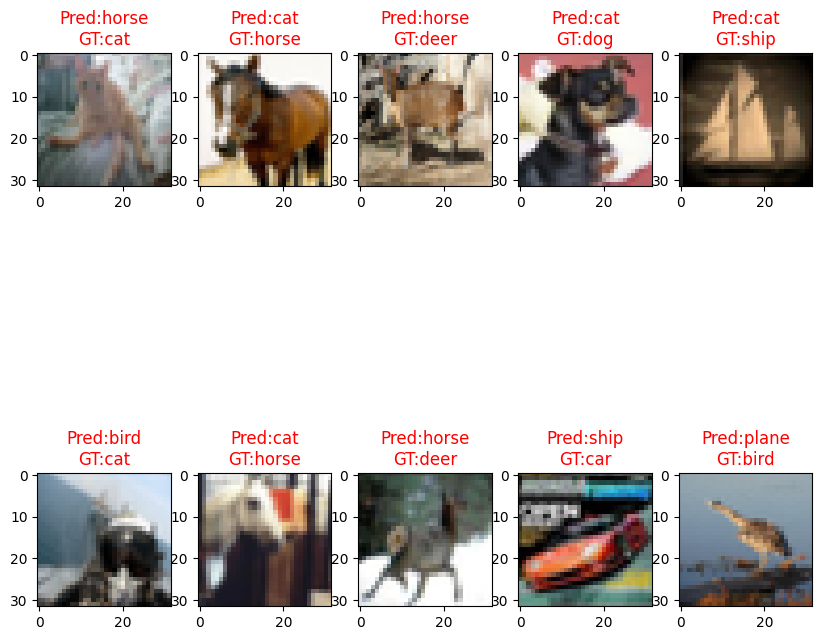

In [14]:
plt.figure(figsize=(10,10))
plt.tight_layout()

right = 0
mistake = 0

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

for i in range(reqData):
    image = images[i]
    pred = classes[incorrectPreds[i]]
    gt = classes[nonMatchingLabels[i]]

    plt.subplot(2,int(reqData/2),i+1)
    plt.imshow(imshow(image))
    plt.axis('on')

    # ret = model.predict(data, batch_size=1)
    #print(ret)

    plt.title("Pred:" + pred + "\nGT:" + gt, color='#ff0000', fontdict={'fontsize': 12})

plt.show()